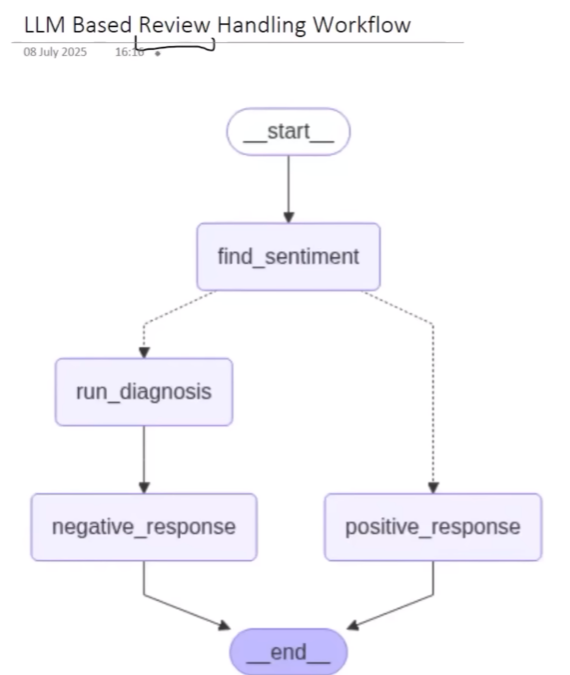

In [23]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import TypedDict, Literal
from dotenv import load_dotenv
from pydantic import BaseModel, Field

In [24]:
load_dotenv()

True

In [25]:
model = ChatOpenAI(model="gpt-4o-mini")

In [26]:
class SentimentSchema(BaseModel):
    sentiment: Literal["positive", "negative"] = Field(description="Sentiment of the review")

In [27]:
class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description='The category of issue mentioned in the review')
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description='The emotional tone expressed by the user')
    urgency: Literal["low", "medium", "high"] = Field(description='How urgent or critical the issue appears to be')

In [28]:
structured_model = model.with_structured_output(SentimentSchema)
structured_model2 = model.with_structured_output(DiagnosisSchema)

In [29]:
prompt = 'What is the sentiment of the following review - The software is good'
structured_model.invoke(prompt)

SentimentSchema(sentiment='positive')

In [30]:
class ReviewState(TypedDict):

    review: str
    sentiment: Literal["positive","negative"]
    diagnosis: dict
    response: str

In [31]:
def find_sentiment(state: ReviewState):

    prompt = f'For the following review find out the sentiment \n {state["review"]}'
    sentiment = structured_model.invoke(prompt).sentiment

    return {'sentiment': sentiment}



In [32]:
def check_sentiment(state: ReviewState) -> Literal["positive_response", "run_diagnosis"]:

    if state['sentiment'] == 'positive':
        return 'positive_response'
    else:
        return 'run_diagnosis'
    


In [33]:
def positive_response(state: ReviewState):

    prompt = f"""Write a warm thank-you message in response to this review:
    \n\n\"{state['review']}\"\n
Also, kindly ask the user to leave feedback on our website."""
    
    response = model.invoke(prompt).content

    return {'response': response}



In [ ]:
def run_diagnosis(state: ReviewState):

    prompt = f"""Diagnose this negative review:\n\n{state['review']}\n"
    "Return issue_type, tone, and urgency.
"""
    response = structured_model2.invoke(prompt)

    return {'diagnosis': response.model_dump()} 
    #here we using model.dump() because the response will be in JSON format 
    # (issue,tone, urgency) so model.dump() will convert the response in JSON 
    # and store in diagnosis



In [35]:
def negative_response(state: ReviewState):

    diagnosis = state['diagnosis']

    prompt = f"""You are a support assistant.
The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as '{diagnosis['urgency']}'.
Write an empathetic, helpful resolution message.
"""
    response = model.invoke(prompt).content

    return {'response': response}

In [36]:
graph = StateGraph(ReviewState)

graph.add_node('find_sentiment', find_sentiment)
graph.add_node('positive_response', positive_response)
graph.add_node('run_diagnosis', run_diagnosis)
graph.add_node('negative_response', negative_response)

In [37]:
graph.add_edge(START, 'find_sentiment')

graph.add_conditional_edges('find_sentiment', check_sentiment)

graph.add_edge('positive_response', END)

graph.add_edge('run_diagnosis', 'negative_response')
graph.add_edge('negative_response', END)

workflow = graph.compile()

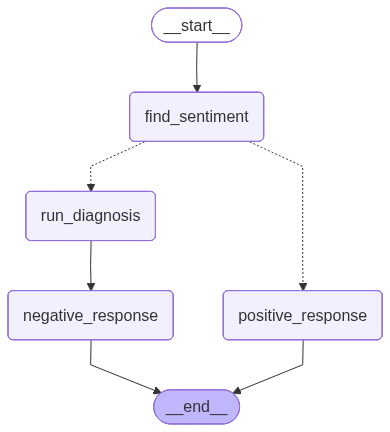

In [38]:
workflow

In [39]:
intial_state={
    'review': "I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality."
}
workflow.invoke(intial_state)

{'review': 'I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality.',
 'sentiment': 'negative',
 'diagnosis': {'issue_type': 'Bug', 'tone': 'frustrated', 'urgency': 'high'},
 'response': "Subject: We're Here to Help with Your Issue\n\nHi [User's Name],\n\nI want to start by sincerely apologizing for the frustration you're experiencing with the bug issue. I understand how stressful it can be when things aren't working as expected, especially with high urgency on your end.\n\nTo help resolve this for you as quickly as possible, could you please provide me with a few more details about the bug? Specifically, any error messages you’re seeing, the steps you took leading up to the issue, and the device or software you're using would be incredibly helpful. \n\nRest assured, we'll do our best to get this sorted out for yo

In [40]:
intial_state={
    'review': "I've been using his app for about a month now, and I must say, the user interface is clean and intuitive"
}
workflow.invoke(intial_state)

{'review': "I've been using his app for about a month now, and I must say, the user interface is clean and intuitive",
 'sentiment': 'positive',
 'response': "Subject: Thank You for Your Kind Words!\n\nHi [User's Name],\n\nThank you so much for taking the time to share your experience with our app! We're thrilled to hear that you find the user interface clean and intuitive. Our team works hard to create a smooth and enjoyable experience, and it’s wonderful to know that it’s resonating with you.\n\nWe’d love to hear any additional feedback you might have! If you have a moment, please consider leaving your thoughts on our website. Your insights are invaluable to us and help us continue to improve.\n\nThanks once again for using our app and for your kind words! \n\nWarm regards,  \n[Your Name]  \n[Your Position]  \n[Company Name]  "}